# Simple Lennard-Jones Fluid

This notebook will walk you through starting a first simulation using the HOOMD-blue simulation software. This software has a python interface.

In [1]:
!pip install -q condacolab
!git clone https://github.com/erjank/563-a1
!git clone --single-branch --branch cecam https://github.com/cmelab/hoomd-organics
import condacolab
condacolab.install()

Cloning into '563-a1'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 87 (delta 34), reused 25 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (87/87), 26.48 MiB | 17.16 MiB/s, done.
Resolving deltas: 100% (34/34), done.
Cloning into 'hoomd-organics'...
remote: Enumerating objects: 3573, done.
remote: Counting objects: 100% (890/890), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 3573 (delta 735), reused 706 (delta 706), pack-reused 2683 (from 1)
Receiving objects: 100% (3573/3573), 1.53 MiB | 9.25 MiB/s, done.
Resolving deltas: 100% (2462/2462), done.
⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:19
🔁 Restarting kernel...


In [1]:
import os
os.chdir("hoomd-organics")
!mamba env update -n base -f environment-cpu.yml
!python -m pip install -e .
import warnings
warnings.filterwarnings('ignore')
os.chdir("../563-a1")


Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.2
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



cudatoolkit-11.8.0   | 682.5 MB  | :   0% 0/1 [00:00<?, ?it/s]
gcc_impl_linux-64-14 | 70.1 MB   | :   0% 0/1 [00:00<?, ?it/s]

pillow-11.1.0        | 40.1 MB   | :   0% 0/1 [00:00<?, ?it/s]


libllvm14-14.0.6     | 30.0 MB   | :   0% 0/1 [00:00<?, ?it/s]



libflint-3.1.3.1     | 20.2 MB   | :   0% 0/1 [00:00<?, ?it/s]




rdkit-2024.09.5      | 19.0 MB   | :   0% 0/1 [00:00<?, ?it/s]





parmed-4.3.0         | 18.5 MB   | :   0% 0/1 [00:00<?, ?it/s]






scipy-1.15.2         | 16.4 MB   | :   0% 0/1 [00:00<?, ?it/s]







libclang-cpp14-14.0. | 15.8 MB   | :   0% 0/1 [00:00<?, ?it/s]








pandas-2.2.3         | 15.0 MB   | :   0% 0/1 [00:00<?, ?it/s]









sysroot_linux-64-2.1 | 14.5 MB   | 

In [2]:
#import the software we will need
import matplotlib.pyplot as plt
import numpy as np
import freud
import hoomd
import gsd.hoomd

In [3]:
def basic_inline_visual(filename, frame):
    with gsd.hoomd.open(filename) as traj:
        frame = traj[frame]

        figure = plt.figure(figsize=(10,10))
        ax = figure.add_subplot(projection='3d')
        pos = frame.particles.position

        ax.scatter(pos[:,0],pos[:,1], pos[:,2])

The first part of creating a simulation in HOOMD is defining the environment in which the simulation will be running. This includes the choice between running on a CPU or GPU. GPU will be faster for large systems, but for small systems (like this workshop) or if you are running locally, then CPU will be necessary.

Second, we will give our simulation a seed. This is a number that will be used to randomize calculations later, ensuring that any two simulations will be different even if they have the same starting point.

In [4]:
#choose here which device to run on
device = hoomd.device.CPU()
# device = hoomd.device.GPU()

seed = np.random.randint(1,1e4)
print('seed is ', seed)

simulation = hoomd.Simulation(device = device, seed = seed)

seed is  7712


Now that we have the simulation object, it will store all of the information about setup, including the particles, their configuration, and the thermostats and integrators that we discussed previously.

# Initialization

The first step of starting a simulation is initialization: identifying all the particles, where they are in space, and the boundaries of our box.

This can get very complicated, because a good initial condition is extremely important to a statistically valid simulation! However, here we can use a fairly easy method. We will define particles in a simple cubic grid, at low pressure and high temperature, and let their motion create a random start. Then, we can slowly cool and compress to the conditions which we want to study.

## Experimenting with dimensionless units
Here we'll set the energy scale of the simulation by choosing KT and $\epsilon$. We'll also experiment with dimensionless units. With your neigbors, choose the same value T* = kT/$\epsilon$ but with different values of kT and $\epsilon$. T* = 1.0 is a ratio to start with.

In [5]:
#Here we'll set simulation parameters like temperature kT and the pair potential

kT = 1.0
#Change these to change the interparticle forces
epsilon = 1.0
sigma = 1.0

#and finally we'll set the density of the system
final_density = 1.0

Now set initial parameters like the dilute system density and the number of particles.

In [6]:
#number density is (number of particles)/(volume)
starting_density = 0.5

#a is the spacing between particles
a = 1/(starting_density**(1/3.0))

#We want a number of particles N in our system.
#Since we will be replicating the system in 3 dimensions, the number of unit cells we need is N^(1/3)
num_replicas = 10
N_particles = num_replicas**3

In [7]:
grid_particles = freud.data.UnitCell([a,a,a,0,0,0],[[0,0,0]]).generate_system(num_replicas)
box_length = grid_particles[0].Lx

GSD is a file format which is compact and useful for storing simulation data. A GSD file is called a trajectory, and consists of a list of frames. Each frame is one snapshot of a simulation, typically moving forward in time. We will save a simulation frame as our initial file.

In [8]:
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles

frame.particles.position = grid_particles[1]
frame.configuration.box = [box_length,box_length,box_length,0,0,0]

#Types of particles define different interactions. In an atomistic simulation these might be C, O, and H.
#in a coarse-grained simulation we can give them a simple name like A
frame.particles.typeid = [0]*N_particles
frame.particles.types = ['A']

#Finally, save our initial state:
with gsd.hoomd.open(name='initial_state.gsd', mode='w') as f:
    f.append(frame)

In [9]:
simulation.create_state_from_gsd(filename='initial_state.gsd')

# Integrators, Thermostats, & Forces

Now we will define how physics works in the simulation. The first part of this is an integrator, which takes a timestep. This code derives acceleration from forces and integrates forward in time to update the particle positions.

*Questions to play around with on your own time:*
*What happens if you drastically increase the timestep? What about if you decrease it?*

In [10]:
integrator = hoomd.md.Integrator(dt = 0.005)

This morning, you learned how to implement various thermostats. You can use the Langevin integrator in HOOMD.

*There are several other thermostats we could have chosen in HOOMD. Many of them add assumed randomness to our system, like Brownian motion. Play around with these on your own time and see how it effects results.*

We also choose the *ensemble*. Typically, this will be an ensemble of constant particle number, volume, and temperature (NVT), but frequently you may choose to set pressure (NPT) or even energy (NVE).

In [11]:
nvt = hoomd.md.methods.Langevin(kT = kT, filter = hoomd.filter.All(),default_gamma = 1.0)
integrator.methods.append(nvt)

Finally, set the forces. Here is where we use the Lennard-Jones model to describe the interparticle forces.

 $$V_{\mathrm{LJ}}(r) = 4 \varepsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]$$

Text(0, 0.5, 'U(r)')

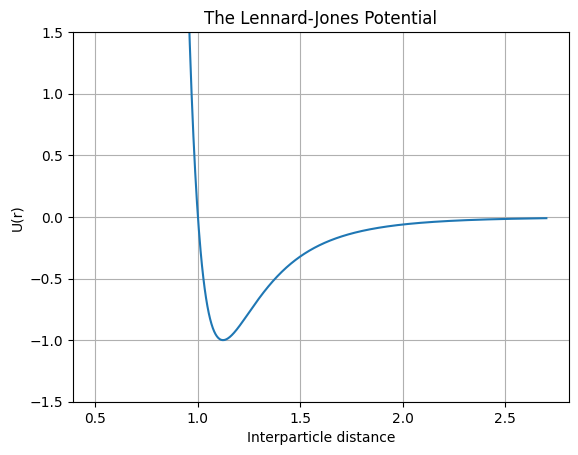

In [12]:
#visualize the LJ potential
rs = np.linspace(0.5,2.7,1000)
def evaluate_lj(e, s, r):
    f = 4*e*((s/r)**12-(s/r)**6)
    return f

potential = [evaluate_lj(epsilon, sigma, r) for r in rs]

plt.plot(rs, potential);
plt.ylim(-1.5,1.5);
plt.title('The Lennard-Jones Potential');
plt.grid('True')
plt.xlabel('Interparticle distance');
plt.ylabel('U(r)')

In [13]:
#hoomd uses a Neighbor List (nlist) to speed up computation
#by only checking forces for particles that are near each other
cell = hoomd.md.nlist.Cell(buffer=0.4)

#Define the force for different particles
lj = hoomd.md.pair.LJ(nlist=cell)

lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

lj.r_cut[('A', 'A')] = 2.7*sigma

r_cut is an important parameter: for any particles farther than r_cut away from each other, the simulation assumes the LJ potential is effectively 0. Making this distance too long slows down computation, but making it too short will truncate the potential unphysically. It's always worth plotting to check if your r_cut is reasonable.

Finally, add everything to the simulation.

In [14]:
integrator.forces.append(lj)
simulation.operations.integrator = integrator

In [15]:
#This will ensure that our particles have a realistic velocity when the simulation begins
simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kT)

thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)

simulation.operations.computes.append(thermodynamic_properties)

# Compress to the desired density

HOOMD handles changing parameters like temperature and density through a Ramp. A Ramp will continuously vary some value over a set number of timesteps, t_ramp.

Here, we will pass the ramp to a "box resize updater" to change the box size slowly.

*This may produce a deprecation warning; you can safely ignore that for now*

In [16]:
compression_steps = int(1e4)

In [17]:
ramp = hoomd.variant.Ramp(A=0, B=1, t_start=simulation.timestep, t_ramp=compression_steps)
initial_box = simulation.state.box
final_box = hoomd.Box.from_box(initial_box)

final_box.volume = simulation.state.N_particles / final_density

box_resize_trigger = hoomd.trigger.Periodic(10)

box_resize = hoomd.update.BoxResize(trigger=box_resize_trigger,
    box1=initial_box, box2=final_box, variant=ramp)

In [18]:
simulation.operations.updaters.append(box_resize)

Finally, we can run the simulation to compress the box.

In [19]:
simulation.run(compression_steps)

Save the final random state as our simulation start point.

In [20]:
hoomd.write.GSD.write(state=simulation.state, filename='random_state.gsd', mode='wb')

Now we will set up to run data collection, sampling the behavior of a Lennard-Jones fluid at the given temperature and density. We will do this for a long time to get a good time-average.

# Record data

This code will log two files:

1. An hdf5 file with number quanities, like how much time has passed, the pressure, and the recorded eenrgy

2. A GSD file which is a "movie" of the particle trajectories.

Importantly, these files are **will not overwrite themselves!** If you run this notebook multiple times, you will need to change the file names to reflect that, or delete old files. Make sure to choose a naming scheme and update file names if you want to save them.

In [22]:
logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
logger.add(simulation)
logger.add(thermodynamic_properties)

#hdf5_writer = hoomd.write.HDF5Log(
#    trigger=hoomd.trigger.Periodic(int(1e4)), filename='log.h5', mode='x', logger=logger
#)

#simulation.operations.writers.append(hdf5_writer)

gsd_writer = hoomd.write.GSD(
    filename='trajectory.gsd',
    trigger=hoomd.trigger.Periodic(int(1e4)),
    mode='xb',
    filter=hoomd.filter.All(),
)

simulation.operations.writers.append(gsd_writer)

#Use this code if you want to save a DCD file for VMD visualization
# dcd = hoomd.write.DCD(trigger=hoomd.trigger.Periodic(int(1e4)),
#                       filename='trajectory_{}.dcd'.format(pressure))
# simulation.operations.writers.append(dcd)

tps_tracking = hoomd.logging.Logger(categories=['scalar', 'string'])
tps_tracking.add(simulation, quantities=['timestep', 'tps'])

table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1e4)), logger=tps_tracking)
simulation.operations.writers.append(table)

# Run the Simulation
To get good statistics, we'll run a very long simulation.

In [23]:
simulation.run(1e5)

Simulation.timestep  Simulation.tps 
       20000           486.89738    
       30000           490.87842    
       40000           492.38559    
       50000           493.15416    
       60000           492.31959    
       70000           491.80360    
       80000           490.41171    
       90000           490.72842    
      100000           491.28698    
      110000           484.97900    


Finally, do some bookkeeping to end the data recording. This isn't necessary in a typical batch script, in which ending the script will automatically flush all the data.

In [ ]:
#simulation.operations.writers.remove(hdf5_writer)
gsd_writer.flush()
simulation.operations.writers.remove(gsd_writer)